In [2]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
from tensorflow.keras import Sequential
from keras.layers import Dense, LSTM

In [3]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

## Import data

In [3]:
dataset = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()
len(dataset)

3019

## Prepare data

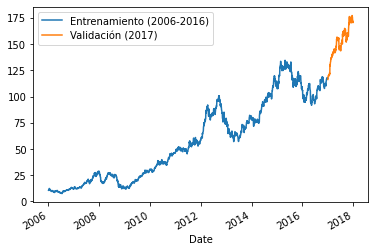

In [5]:
set_entrenamiento = dataset[:'2016'].iloc[:,1:2]
set_validacion = dataset['2017':].iloc[:,1:2]

set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Model training

In [6]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50
# Model definition
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
# Model training
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
85/85 [==============================] - 5s 25ms/step - loss: 0.0151
Epoch 2/20
85/85 [==============================] - 2s 24ms/step - loss: 9.5801e-04
Epoch 3/20
85/85 [==============================] - 2s 23ms/step - loss: 7.2406e-04
Epoch 4/20
85/85 [==============================] - 2s 24ms/step - loss: 7.0455e-04
Epoch 5/20
85/85 [==============================] - 2s 23ms/step - loss: 4.5669e-04
Epoch 6/20
85/85 [==============================] - 2s 24ms/step - loss: 4.0635e-04
Epoch 7/20
85/85 [==============================] - 2s 24ms/step - loss: 4.0068e-04
Epoch 8/20
85/85 [==============================] - 2s 25ms/step - loss: 3.9824e-04
Epoch 9/20
85/85 [==============================] - 2s 26ms/step - loss: 3.0647e-04
Epoch 10/20
85/85 [==============================] - 2s 24ms/step - loss: 3.2143e-04: 0s - loss: 3.2316
Epoch 11/20
85/85 [==============================] - 2s 24ms/step - loss: 2.5589e-04
Epoch 12/20
85/85 [==============================] - 2s 24m

## Model validation

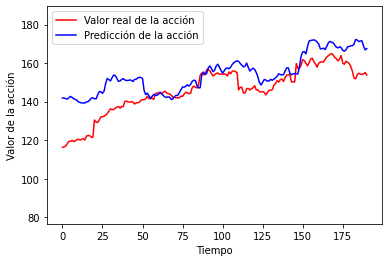

In [7]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)